In [16]:
from scipy import signal
import scipy
import numpy as np
import matplotlib.pyplot as plt


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def error_bound(a, b, err):
    n = np.log((b - a) / err) / np.log(2)
    return int(np.ceil(n))
    
def validate_interval(f, x0, x1):
    var1 = f(x0)
    var2 = f(x1)
    return  var1*var2 < 0
# solve for root using bisection method
def bisection(f, interval, tol):
    """
    param f: find root for function
    param interval: within range
    param tol: root accuracy tolerance
    """

    # extract interval start and end points
    x0, x1 = interval[0], interval[1]

    if x0>x1:
        xaux = x0
        x0=x1
        x1=xaux


    # check interval can be used to solve for root
    if not validate_interval(f, x0, x1):
        return

    # iterations required to find the root within a specified error bound
    n = error_bound(x0, x1, tol)

    counter = 1

    # iterate over error bound
    while True:

        # calculate root approximation
        root_approx = x0 + ((x1 - x0) / 2)

        # evaluate y at current estimate
        y = f(root_approx)

        # check tolerance condition
        if -tol < y < tol:
            # check that error bound actually worked
            print(counter, n)

            # return root approximation
            return root_approx

        # check if next segment is left of bisection
        if validate_interval(f, x0, root_approx):
            x1 = root_approx
        else:
            x0 = root_approx

        # increment counter
        counter += 1


7 9
7 10
13 12
10 13


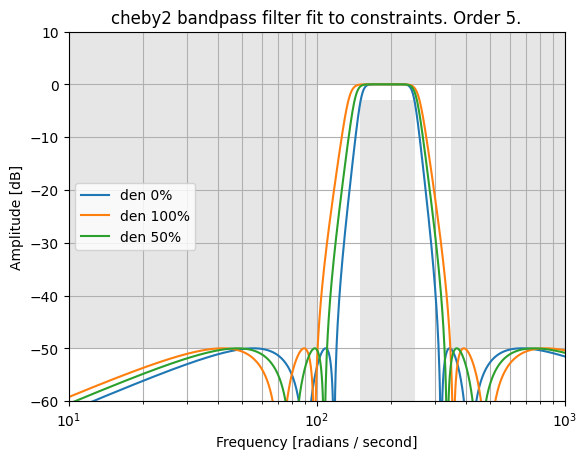

TransferFunctionContinuous(
array([3.44421761e+00, 0.00000000e+00, 1.15207730e+06, 0.00000000e+00,
       9.91514828e+10, 0.00000000e+00, 1.50755652e+15, 0.00000000e+00,
       5.89758970e+18, 0.00000000e+00]),
array([1.00000000e+00, 3.77517899e+02, 2.52123725e+05, 6.29947476e+07,
       2.14369781e+10, 3.59434743e+12, 7.75460280e+14, 8.24320928e+16,
       1.19344304e+19, 6.46430024e+20, 6.19412499e+22]),
dt: None
)


In [49]:
from msilib import type_string
from scipy import signal
import scipy
import numpy as np
import matplotlib.pyplot as plt

def get_min_order(filter_name, Wpass, Watt, Gp, Ga):
    if filter_name == 'butter':
        ordfunc = signal.buttord
    elif filter_name == 'cheby':
        ordfunc = signal.cheb1ord
    elif filter_name == 'cheby2':
        ordfunc = signal.cheb2ord
    elif filter_name == 'cauer':
        ordfunc = signal.ellipord
    else:
        return
    return ordfunc(Wpass, Watt, Gp, Ga, True)


def get_filter(filter_name, filter_type, N, Wn,Gp, Ga, denorm):

    

    if filter_name == 'butter':
        filterfunc = signal.butter
    elif filter_name == 'cheby':
        filterfunc = lambda ord, w3db, type_str, analog: signal.cheby1(ord, -Gp, w3db, type_str, analog)
    elif filter_name == 'cheby2':
        filterfunc = lambda ord, w3db, type_str, analog: signal.cheby2(ord, -Ga, w3db, type_str, analog)
    elif filter_name == 'cauer':
        filterfunc = lambda ord, w3db, type_str, analog: signal.ellip(ord, -Gp, -Ga, w3db, type_str, analog)
    else:
        return
    
    def getMagnAtWx (order, W3db, Wx):
        num, den = filterfunc(order, W3db, filter_type, True)
        w, h = signal.freqs(num, den, [Wx])
        res = 20*np.log10(abs(h[0]))
        return(res)


    
    b1, a1 = filterfunc(N, Wn, filter_type, True)
 
    #Busco dos frecuencias para podes hallar una que clave exacto Gp en Wp
    if filter_type=='lowpass':
        Wp1 = Wn
        while (getMagnAtWx(N,Wp1,Wpass)>Gp):
            Wp1*=0.99    
        Wp2 = Wn*1.02
        Wn0 = 1.01*bisection(lambda x: getMagnAtWx(N, x, Wpass)-(Gp), [Wp1, Wp2], 0.01)
    elif filter_type=='highpass':
        Wp1 = Wn
        while (getMagnAtWx(N,Wp1,Wpass)>Gp):
            Wp1*=1.01    
        Wp2 = Wn*0.98
        Wn0 = 0.99*bisection(lambda x: getMagnAtWx(N, x, Wpass)-(Gp), [Wp1, Wp2], 0.01)
    elif filter_type=='bandpass':
        Wn0 = []
        WaA1 = Wn[0]
        while (getMagnAtWx(N,[WaA1,Wn[1]],Wpass[0])>Gp):
            WaA1*=1.01    
        WpA2 = Wn[0]*0.98
        Wn0.append(1.01*bisection(lambda x: getMagnAtWx(N, [x,Wn[1]], Wpass[0])-(Gp), [WaA1, WpA2], 0.01))

        WpB1 = Wn[1]
        while (getMagnAtWx(N,[Wn0[0],WpB1],Wpass[1])>Gp):
            WpB1*=0.99    
        WpB2 = Wn[1]*1.02

        magB1 = getMagnAtWx(N,[Wn0[0],WpB1],Wpass[1])
        magB2 = getMagnAtWx(N,[Wn0[0],WpB2],Wpass[1])

        var = 0.99*bisection(lambda x: getMagnAtWx(N, [Wn0[0],x], Wpass[1])-(Gp), [WpB2, WpB1], 0.01)

        Wn0.append(var)
    elif filter_type=='bandstop':
        Wn0 = []
        WaA1 = Wn[0]
        while (getMagnAtWx(N,[WaA1,Wn[1]],Wpass[0])>Gp):
            WaA1*=0.99    
        WpA2 = Wn[0]*1.02
        Wn0.append(1.01*bisection(lambda x: getMagnAtWx(N, [x,Wn[1]], Wpass[0])-(Gp), [WaA1, WpA2], 0.01))

        WpB1 = Wn[1]
        while (getMagnAtWx(N,[Wn0[0],WpB1],Wpass[1])>Gp):
            WpB1*=1.01    
        WpB2 = Wn[1]*0.98

        magB1 = getMagnAtWx(N,[Wn0[0],WpB1],Wpass[1])
        magB2 = getMagnAtWx(N,[Wn0[0],WpB2],Wpass[1])

        var = 0.99*bisection(lambda x: getMagnAtWx(N, [Wn0[0],x], Wpass[1])-(Gp), [WpB2, WpB1], 0.01)

        Wn0.append(var)

    

    if filter_type=='lowpass':
        Wa1 = Wn
        while (getMagnAtWx(N,Wa1,Watt)<Ga):
            gan = getMagnAtWx(N,Wa1,Watt)
            Wa1*=1.01   
        Wa2 = Wn*0.98
        Wn100 = 0.99*bisection(lambda x: getMagnAtWx(N, x, Watt)-(Ga), [Wa1, Wa2], 0.01)
    elif filter_type=='highpass':
        Wa1 = Wn
        while (getMagnAtWx(N,Wa1,Watt)<Ga):
            Wa1*=0.99    
        Wa2 = Wn*1.02
        Wn100 = 1.01*bisection(lambda x: getMagnAtWx(N, x, Watt)-(Ga), [Wa1, Wa2], 0.01)
    elif filter_type=='bandpass':
        Wn100 = []
        WaA1 = Wn[0]
        while (getMagnAtWx(N,[WaA1,Wn[1]],Watt[0])<Ga):
            WaA1*=0.99    
        WaA2 = Wn[0]*1.02

        magA1 = getMagnAtWx(N,[WaA1, Wn[1]],Watt[0])
        magA2 = getMagnAtWx(N,[WaA2, Wn[1]],Watt[0])

        Wn100.append(1.01*bisection(lambda x: getMagnAtWx(N, [x,Wn[1]], Watt[0])-(Ga), [WaA1, WaA2], 0.01))

        WaB1 = Wn[1]
        while (getMagnAtWx(N,[Wn100[0],WaB1],Watt[1])<Ga):
            val = getMagnAtWx(N,[Wn100[0],WaB1],Watt[1])
            WaB1*=1.01  
        WaB2 = Wn[1]*0.98

        magB1 = getMagnAtWx(N,[Wn100[0],WaB1],Watt[1])
        magB2 = getMagnAtWx(N,[Wn100[0],WaB2],Watt[1])

        var = 0.99*bisection(lambda x: getMagnAtWx(N, [Wn100[0],x], Watt[1])-(Ga), [WaB2, WaB1], 0.01)

        Wn100.append(var)
    elif filter_type=='bandstop':
        Wn100 = []
        WaA1 = Wn[0]
        while (getMagnAtWx(N,[WaA1,Wn[1]],Watt[0])<Ga):
            WaA1*=1.01    
        WaA2 = Wn[0]*0.98

        magA1 = getMagnAtWx(N,[WaA1, Wn[1]],Watt[0])
        magA2 = getMagnAtWx(N,[WaA2, Wn[1]],Watt[0])

        Wn100.append(1.01*bisection(lambda x: getMagnAtWx(N, [x,Wn[1]], Watt[0])-(Ga), [WaA1, WaA2], 0.01))

        WaB1 = Wn[1]
        while (getMagnAtWx(N,[Wn100[0],WaB1],Watt[1])<Ga):
            val = getMagnAtWx(N,[Wn100[0],WaB1],Watt[1])
            WaB1*=0.99   
        WaB2 = Wn[1]*1.02

        magB1 = getMagnAtWx(N,[Wn100[0],WaB1],Watt[1])
        magB2 = getMagnAtWx(N,[Wn100[0],WaB2],Watt[1])

        var = 0.99*bisection(lambda x: getMagnAtWx(N, [Wn100[0],x], Watt[1])-(Ga), [WaB2, WaB1], 0.01)

        Wn100.append(var)
        

    



    b2, a2 = filterfunc(N, Wn100, filter_type, True)
    w, h2 = signal.freqs(b2, a2, np.logspace(1, 3, 1000))

    if (filter_type == 'bandpass' or filter_type == 'bandstop'):
        Wden = [0,0]
        for index,element in enumerate(Wden):
            Wden[index]=Wn0[index]**(denorm)*Wn100[index]**(1-denorm)
    else:
        Wden = Wn0**(denorm)*Wn100**(1-denorm)

    b3, a3 = filterfunc(N, Wden, filter_type, True)
    w, h3 = signal.freqs(b3, a3, np.logspace(1, 3, 1000))

    b4, a4 = filterfunc(N, Wn0, filter_type, True)
    w, h4 = signal.freqs(b4, a4, np.logspace(1, 3, 1000))



    plt.semilogx(w, 20 * np.log10(abs(h4)), label='den 0%')
    plt.semilogx(w, 20 * np.log10(abs(h2)), label='den 100%')
    plt.semilogx(w, 20 * np.log10(abs(h3)), label='den 50%')

    plt.title(filter_name + ' ' + filter_type + ' filter fit to constraints. Order '+str(N)+'.')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.grid(which='both', axis='both')
    if filter_type =='lowpass':
        plt.fill([0.01*Wpass,  0.01*Wpass,  100*Watt,   100*Watt],[0, 100*(-Gp), 100*(-Gp), 0], '0.9', lw=0) #zona prohibida: amplificación
        plt.fill([0.01*Wpass,  0.01*Wpass,  Wpass,   Wpass],[100*Gp, Gp, Gp, 100*Gp], '0.9', lw=0) #zona prohibida: bajo Gp
        plt.fill([Watt,  100*Watt, 100*Watt, Watt],[0, 0, Ga, Ga], '0.9', lw=0) #zona prohibida: sobre Ga
        
    if filter_type =='highpass':
        plt.fill([0.01*Wpass,  0.01*Wpass,  100*Watt,   100*Watt],[0, 100*(-Gp), 100*(-Gp), 0], '0.9', lw=0) #zona prohibida: amplificación
        plt.fill([0.01*Watt,  0.01*Watt,  Watt,   Watt],[0, Ga, Ga, 0], '0.9', lw=0) #zona prohibida: bajo Gp
        plt.fill([Wpass,  100*Wpass, 100*Wpass, Wpass],[Gp, Gp, 100*Gp, 100*Gp], '0.9', lw=0) #zona prohibida: sobre Ga

    if filter_type =='bandpass':
        plt.fill([1,  1,  100*Watt[1],   100*Watt[1]],[0, 100*(-Gp), 100*(-Gp), 0], '0.9', lw=0) #zona prohibida: amplificación
        plt.fill([1,  1,  Watt[0],  Watt[0]],[0, Ga, Ga, 0], '0.9', lw=0) #zona prohibida: bajo Gp
        plt.fill([Watt[1],  Watt[1],  100*Watt[1],  100*Watt[1]],[0, Ga, Ga, 0], '0.9', lw=0) #zona prohibida: bajo Gp
        plt.fill([Wpass[0],  Wpass[0], Wpass[1], Wpass[1]],[Gp, 100*Gp, 100*Gp, Gp], '0.9', lw=0) #zona prohibida: sobre Ga
    
    if filter_type =='bandstop':
        plt.fill([1,  1,  100*Wpass[1],   100*Wpass[1]],[0, 100*(-Gp), 100*(-Gp), 0], '0.9', lw=0) #zona prohibida: amplificación
        plt.fill([1,  1,  Wpass[0],  Wpass[0]],[Gp, 100*Gp, 100*Gp, Gp], '0.9', lw=0) #zona prohibida: bajo Gp
        plt.fill([Wpass[1],  Wpass[1],100*Wpass[1],  100*Wpass[1]],[Gp, 100*Gp, 100*Gp, Gp], '0.9', lw=0) #zona prohibida: bajo Gp
        plt.fill([Watt[0],  Watt[0],  Watt[1],  Watt[1]],[0, Ga, Ga, 0], '0.9', lw=0) #zona prohibida: bajo Gp


    # stop
    plt.axis([10, 1000, Ga-10, 10])
    plt.legend()
    plt.show()
    return [b3, a3],[b1,a1]

""" 
    'butter'
    'cheby'
    'cheby2'
    'cauer'
"""

filter = 'cheby2'
filter_type = 'bandpass'
Wpass = [150,250]
Watt = [100,350]
Gp = -3
Ga = -50
deg = 0.5

order, Wn = get_min_order(filter, Wpass, Watt, -Gp, -Ga)

b, a = get_filter(filter,filter_type, order, Wn, Gp,Ga,0.5)[0]
b, a = signal.normalize(b,a)
print(signal.TransferFunction(b,a))
